### Basic Sentiment Analysis

Basic sentiment analysis pipeline to determine the trend in sentiment for a particular set of scraped data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

In [ ]:
df = pd.read_parquet("../../data/reddit/nlp_analysis/loseit_topall_searchOzempic.parquet")
len(df[df["sentiment"] == "Negative"])
# df.sort_values(by=["mh_score"], ascending=False)
# df.head()

6806

In [ ]:
df = pd.read_parquet("../../data/reddit/nlp_analysis/loseit_topall_searchOzempic.parquet")

def flatten_df(df: pd.DataFrame) -> pd.DataFrame:
    flattened_rows = []

    for idx, row in df.iterrows():
        flattened_rows.append({
            "type": "post",
            "post_index": idx,
            "content": f"{row['title']}. {row['content']}",
            "upvotes": row['upvotes'],
            "timestamp": row['timestamp']
        })

        # Add each comment as its own row
        for comment in row.get("comments", []):
            flattened_rows.append({
                "type": "comment",
                "post_index": idx,
                "content": comment['content'],
                "upvotes": comment["upvotes"],
                "timestamp": comment['timestamp']
            })

    return pd.DataFrame(flattened_rows)

# Ensure timestamp is in datetime format
df = flatten_df(df)
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df["year_month"] = df["datetime"].dt.to_period("M")

In [4]:
# Set up the sentiment and emotion classifier pipelines
sentimentPipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
emotionPipeline = pipeline("text-classification", 
                            model="j-hartmann/emotion-english-distilroberta-base")

Device set to use cpu
Device set to use cpu


In [36]:
pred = max(emotionPipeline("This is such an awful library!")[0], key=lambda x: x["score"])
pred

{'label': 'disgust', 'score': 0.9512102603912354}

In [39]:
def getArgmaxEmotion(text: str):
    return max(emotionPipeline(text[:512])[0], key=lambda x: x["score"])

df["emotion_result"] = df["content"].apply(getArgmaxEmotion)

# Split into label and score
df["emotion"] = df["emotion_result"].apply(lambda x: x["label"])
df["emotion_score"] = df["emotion_result"].apply(lambda x: x["score"])

In [41]:
df.tail()

,type,post_index,content,upvotes,timestamp,datetime,year_month,emotion_result,emotion,emotion_score
6801,comment,234,Any weight loss updates? I'm starting metformi...,1,1.707231e+09,2024-02-06 14:53:07,2024-02,"{'label': 'neutral', 'score': 0.7842847108840942}",neutral,0.784285
6802,comment,234,I was only on it for a week and it was making ...,2,1.682887e+09,2023-04-30 20:31:58,2023-04,"{'label': 'sadness', 'score': 0.3444141745567322}",sadness,0.344414
6803,comment,234,"I know this is an old post, but I recently sta...",27,1.687514e+09,2023-06-23 09:56:18,2023-06,"{'label': 'neutral', 'score': 0.720175564289093}",neutral,0.720176
6804,comment,234,I recently switched to wegovy but it did help ...,4,1.676235e+09,2023-02-12 20:58:01,2023-02,"{'label': 'neutral', 'score': 0.6497548818588257}",neutral,0.649755
6805,comment,234,"Start with 500 mg of Metformin RX once a day, ...",5,1.693563e+09,2023-09-01 10:05:23,2023-09,"{'label': 'neutral', 'score': 0.949388861656189}",neutral,0.949389


In [5]:
# Apply sentiment analysis to all posts
df["sentiment_result"] = df["content"].apply(lambda x: sentimentPipeline(x[:512])[0])

# Split into label and score
df["sentiment"] = df["sentiment_result"].apply(lambda x: x["label"])
df["sentiment_score"] = df["sentiment_result"].apply(lambda x: x["score"])

KeyboardInterrupt: 

In [30]:
len(df[df["sentiment"] == "Negative"])

1801

In [22]:
def convertToLabel(label: str):
    match label:
        case "LABEL_0":
            return "Negative"
        case "LABEL_1":
            return "Neutral"
        case "LABEL_2":
            return "Positive"

df["sentiment"] = df["sentiment"].apply(convertToLabel)

In [23]:
# Aggregate sentiment by time
monthly_sentiment = df.groupby(["year_month", "sentiment"]).size().unstack(fill_value=0)

# Normalize to get proportions
monthly_sentiment_prop = monthly_sentiment.div(monthly_sentiment.sum(axis=1), axis=0)

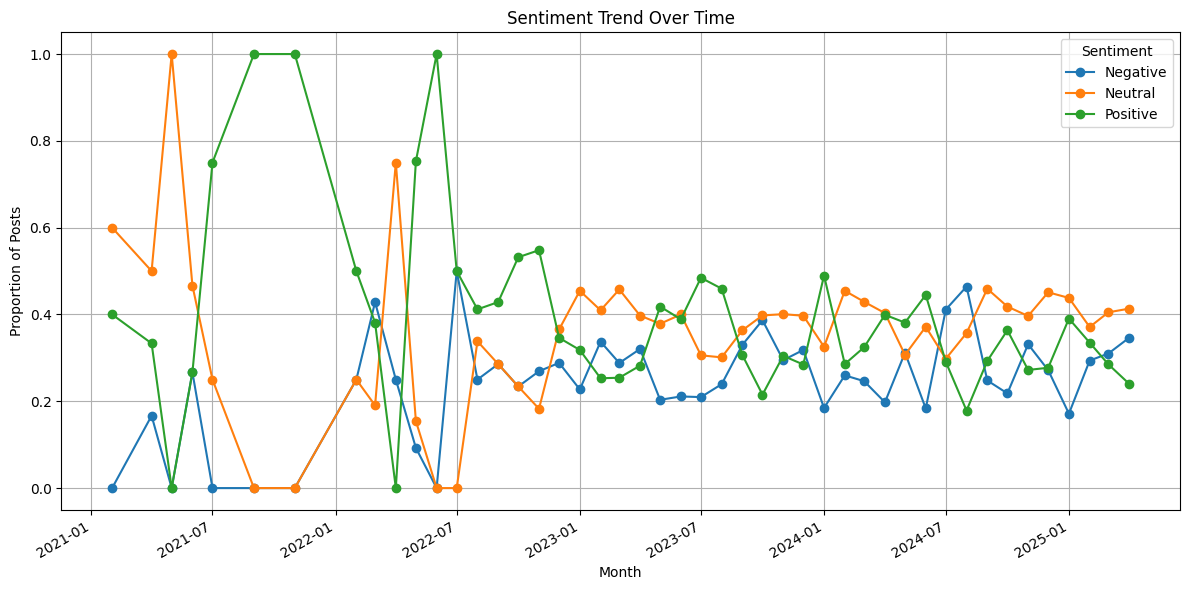

In [ ]:
# Convert nidex back to datetime for better plotting
monthly_sentiment_prop.index = monthly_sentiment_prop.index.to_timestamp()

# Compute a rolling average with a window size
monthly_sentiment_smoothed = monthly_sentiment_prop.rolling(window=3).mean()

# Plot
monthly_sentiment_smoothed.plot(figsize=(12, 6), marker="o")
plt.title("Sentiment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Proportion of Posts")
plt.legend(title="Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()

### TODO:

1. Trim the line plot to not show any points where the data is too sparse
2. Get insights into the topics of positive vs negative posts
3. Run some test to determine if there is any seasonality in the sentiment trend
4. Get more emotion insights into the specific comments (more fine-grained emotion classification)
5. Implement scripts to automate data visualization creation for all of these datasets
6. Compare top 10 topics before and after Ozempic in multiple subreddits. Also compare sentiment before and after Ozempic in multiple subreddits. Do this using some kind of statistical significance test (Chi-Squared)
    - Also determine if distribution of sentiment differs significantly between stigma topics and other topics
7. Compare sentiment and topics in pop culture subreddits versus other more critical subreddits (diabetes, EatingDisorders)
8. Build Mental Health Score from Bag-of-Words approach to determine if there is any significant correlation between discussion and bad mental health
    - Alternatively, use CLPsuch Shared Task Models, LIWC, MentalBERT/RoBERTa, etc. to detect mental health language in extracted posts
9. Work with metadata to determine and compare the sentiment and topics between posts with a high vs low upvote ratio, etc.
10. ??? Train a classifier to detect post categories for negative sentiment posts (stigma, cost, diabetes, etc.). Try to determine if the distribution of stigma labelled posts is significantly larger than that of other problems
11. Word Embeddings and Semantic Analysis and see how "Ozempic" is semantically positioned in the different communities -- is it closer to medical associations, or closer to pop culture associations, etc.
12. Discourse structure analysis (claim markers vs evidence markers)
13. Time-series and Changepoint detection